In [734]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn
import matplotlib.pyplot as plt
from vqf import VQF, offlineVQF

In [735]:
# Get directories for IMU data
forearmPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111"#askdirectory(title='Select Folder Containing Forearm Data') # shows dialog box and return the path
print(forearmPath)
armPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111"#askdirectory(title='Select Folder Containing Arm Data') # shows dialog box and return the path
print(armPath)
foreArmGData = pandas.read_csv("{}/Gyroscope.csv".format(forearmPath))
armGData = pandas.read_csv("{}/Gyroscope.csv".format(armPath))
foreArmAData = pandas.read_csv("{}/Accelerometer.csv".format(forearmPath))
armAData = pandas.read_csv("{}/Accelerometer.csv".format(armPath))
foreArmMData = pandas.read_csv("{}/Magnetometer.csv".format(forearmPath))
armMData = pandas.read_csv("{}/Magnetometer.csv".format(armPath))
# Truncate data to have same number of samples (temporary with contrived data)
minDataLength = min([len(armGData), len(foreArmGData), len(armMData), len(foreArmAData), len(armMData), len(foreArmMData)])
foreArmGData = foreArmGData[:minDataLength]
armGData = armGData[:minDataLength]
foreArmAData = foreArmAData[:minDataLength]
armAData = armAData[:minDataLength]
foreArmMData = foreArmMData[:minDataLength]
armMData = armMData[:minDataLength]

# Number of samples a second to resample data at and valiue in Hz
reSamples = 15.0
reSampleRate = 1.0/reSamples

# Initialize gyroscope data array(g1, g2) (2 arrays with # rows equal to # sample and each row [x, y, z])
gDataRaw = numpy.array([numpy.stack([foreArmGData['X (rad/s)'].values, foreArmGData['Y (rad/s)'].values, foreArmGData['Z (rad/s)'].values], 1),\
                    numpy.stack([armGData['X (rad/s)'].values, armGData['Y (rad/s)'].values, armGData['Z (rad/s)'].values], 1)])
# Calculate new time vectors with sample grouping between samples in seconds
timeVForeG = numpy.floor((foreArmGData['Time (s)'].values/reSampleRate))
timeVArmG = numpy.floor((armGData['Time (s)'].values/reSampleRate))
#create new data arrays with same timebase
gFore = []
for i in range(numpy.int32(numpy.max(timeVForeG))):
    newRow1 = numpy.mean(gDataRaw[0][numpy.where(timeVForeG == i)], axis=0)
    gFore.append(list(newRow1))
gFore = numpy.array(gFore)
gArm = []
for i in range(numpy.int32(numpy.max(timeVArmG))):
    newRow2 = numpy.mean(gDataRaw[1][numpy.where(timeVArmG == i)], axis=0)
    gArm.append(numpy.array(newRow2))
gArm = numpy.array(gArm)
minLen = min([len(gArm), len(gFore)])
gFore = gFore[:minLen]
gArm = gArm[:minLen]
gData = numpy.array([numpy.array(gFore), numpy.array(gArm)])

# Initialize accelerometer data array (a1, a1) (2 arrays with # rows equal to # samples and each row [x, y, z])
aDataRaw = numpy.array([numpy.stack([foreArmAData['X (m/s^2)'].values, foreArmAData['Y (m/s^2)'].values, foreArmAData['Z (m/s^2)'].values], 1),\
                    numpy.stack([armAData['X (m/s^2)'].values, armAData['Y (m/s^2)'].values, armAData['Z (m/s^2)'].values], 1)])
# Calculate new time vectors with sample grouping between samples in seconds
timeVForeA = numpy.floor((foreArmAData['Time (s)'].values/reSampleRate))
timeVArmA = numpy.floor((armAData['Time (s)'].values/reSampleRate))
#create new data arrays with same timebase
aFore = []
for i in range(numpy.int32(numpy.max(timeVForeA))):
    newRow1 = numpy.mean(aDataRaw[0][numpy.where(timeVForeA == i)], axis=0)
    aFore.append(list(newRow1))
aFore = numpy.array(gFore)
aArm = []
for i in range(numpy.int32(numpy.max(timeVArmA))):
    newRow2 = numpy.mean(aDataRaw[1][numpy.where(timeVArmA == i)], axis=0)
    aArm.append(numpy.array(newRow2))
aArm = numpy.array(aArm)
minLen = min([len(aArm), len(aFore)])
aFore = aFore[:minLen]
aArm = aArm[:minLen]
aData = numpy.array([numpy.array(aFore), numpy.array(aArm)])

# Initialize magnetometer data array (m1, m1) (2 arrays with # rows equal to # samples and each row [x, y, z])
mDataRaw = numpy.array([numpy.stack([foreArmMData['X (µT)'].values, foreArmMData['Y (µT)'].values, foreArmMData['Z (µT)'].values], 1),\
                    numpy.stack([armMData['X (µT)'].values, armMData['Y (µT)'].values, armMData['Z (µT)'].values], 1)])
# Number of samples a second to resample data in Hz and valiue in s
reSamples = 15.0
reSampleRate = 1.0/reSamples
# Calculate new time vectors with sample grouping between samples in seconds
timeVForeM = numpy.floor((foreArmMData['Time (s)'].values/reSampleRate))
timeVArmM = numpy.floor((armMData['Time (s)'].values/reSampleRate))
#create new data arrays with same timebase
mFore = []
for i in range(numpy.int32(numpy.max(timeVForeM))):
    newRow1 = numpy.mean(mDataRaw[0][numpy.where(timeVForeM == i)], axis=0)
    mFore.append(list(newRow1))
mFore = numpy.array(mFore)
mArm = []
for i in range(numpy.int32(numpy.max(timeVArmM))):
    newRow2 = numpy.mean(mDataRaw[1][numpy.where(timeVArmM == i)], axis=0)
    mArm.append(numpy.array(newRow2))
mArm = numpy.array(mArm)
minLen = min([len(mArm), len(mFore)])
mFore = mFore[:minLen]
mArm = mArm[:minLen]
mData = numpy.array([numpy.array(mFore), numpy.array(mArm)])

/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111
/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111


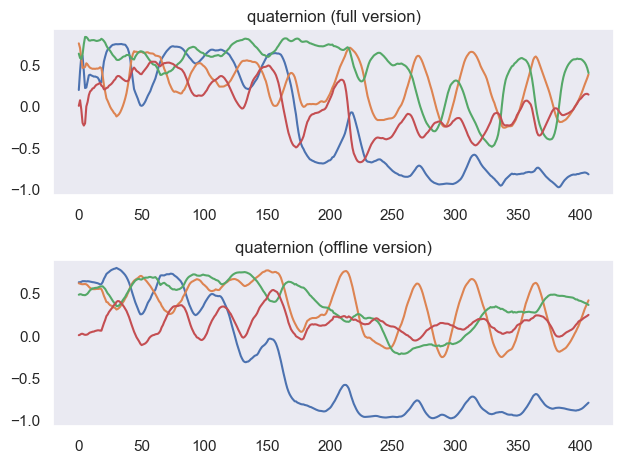

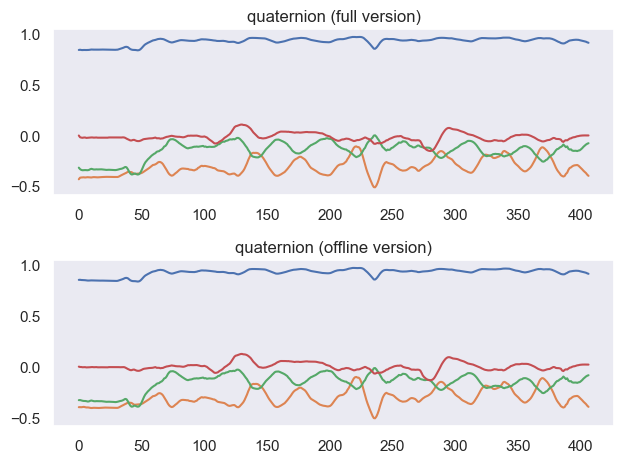

In [727]:
# Playing with quaternions
vqf1 = VQF(reSampleRate)
vqfOffline1 = offlineVQF(gData[0], aData[0], mData[0], reSampleRate)
# alternative: vqf = PyVQF(Ts)
out1 = vqf1.updateBatch(gData[0], aData[0])
outOffline1 = vqfOffline1#.updateBatch(gData[0], aData[0])

# plot the quaternion of the forearm sensor
plt.figure()
plt.subplot(211)
plt.plot(outOffline1['quat6D'])
plt.title('quaternion (full version)')
plt.grid()
plt.subplot(212)
plt.plot(outOffline1['quat9D'])
plt.grid()
plt.title('quaternion (offline version)')
plt.tight_layout()
plt.show()

vqf2 = VQF(reSampleRate)
vqfOffline2 = offlineVQF(gData[1], aData[1], mData[1], reSampleRate)
# alternative: vqf = PyVQF(Ts)
out2 = vqf2.updateBatch(gData[1], aData[1])
outOffline2 = vqfOffline2#.updateBatch(gData[1], aData[1])

# plot the quaternion of the arm sensor
plt.figure()
plt.subplot(211)
plt.plot(outOffline2['quat6D'])
plt.title('quaternion (full version)')
plt.grid()
plt.subplot(212)
plt.plot(outOffline2['quat9D'])
plt.grid()
plt.title('quaternion (offline version)')
plt.tight_layout()
plt.show()

46


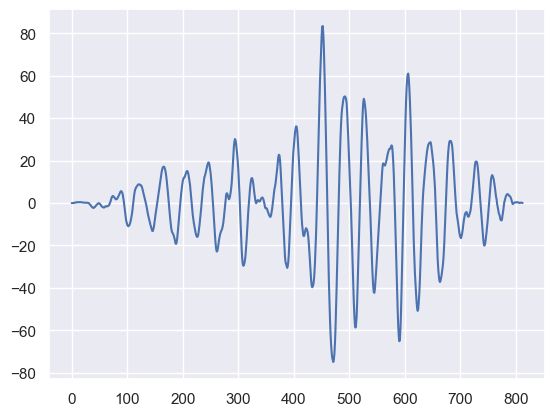

46


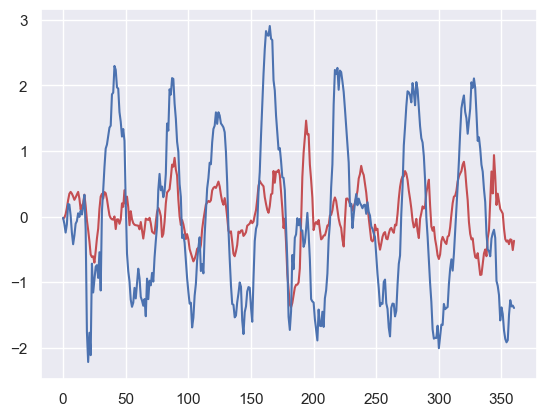

In [728]:
corr = numpy.correlate(gArm[:,0] - numpy.mean(gArm[:,0]), gFore[:,0] - numpy.mean(gFore[:,0]), mode='full')
lag = corr.argmax() - (len(gArm[:,0]) - 1)
print(lag)
plt.plot(corr)
plt.show()
print(lag)
plt.plot(gArm[lag:,0] - numpy.mean(gArm[:,0]), 'r-')
plt.plot(gFore[:-lag,0] - numpy.mean(gFore[:,0]), 'b-')
plt.show()
gArm = gArm[lag:]
gFore = gFore[:-lag]
gData = numpy.array([numpy.array(gFore[:]), numpy.array(gArm[:])])

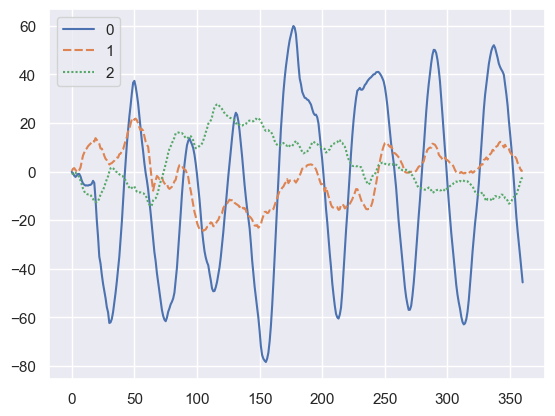

In [729]:
# Calculate time delta between samples in seconds
deltat = reSampleRate#numpy.average(numpy.diff(foreArmGData['Time (s)'].values))
# Calculate angle moved for each time step by integrating gyroscope data over time
angleSteps = gData * deltat
angleData = numpy.cumsum(angleSteps, axis=1)
degreeData = numpy.rad2deg(angleData)
seaborn.set(style="darkgrid")
a = seaborn.lineplot(data=degreeData[0])

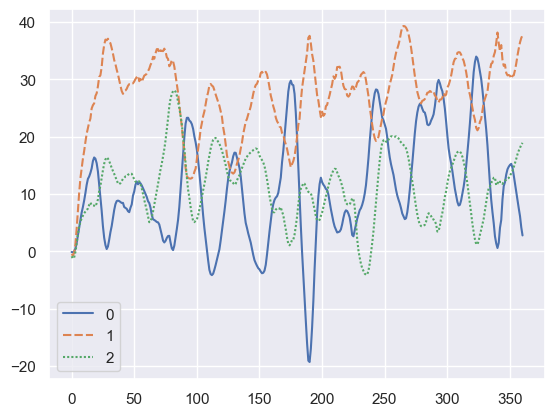

In [730]:

b = seaborn.lineplot(data=degreeData[1])

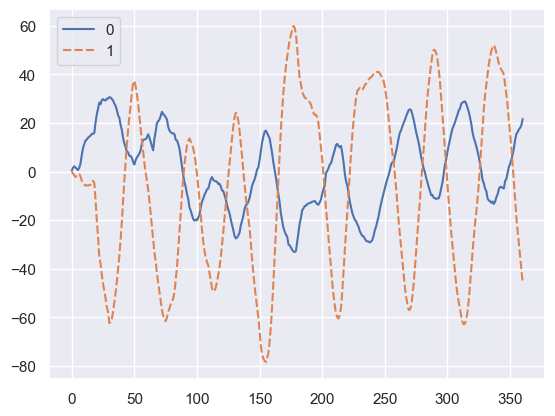

In [731]:
def getJEst(aEst):
    j1Est = numpy.array([numpy.cos(aEst[0][1])*numpy.cos(aEst[0][2]), numpy.cos(aEst[0][1])*numpy.sin(aEst[0][2]), numpy.sin(aEst[0][1])])
    j2Est = numpy.array([numpy.cos(aEst[1][1])*numpy.cos(aEst[1][2]), numpy.cos(aEst[1][1])*numpy.sin(aEst[1][2]), numpy.sin(aEst[1][1])])
    return numpy.array([j1Est, j2Est])


# Vector of angle and azimuth values for such that theta unit vector is parallel to x axis, perp to z and y (x axis is hinge axis)
aaVec = numpy.random.rand(2, 3)*numpy.pi*2#numpy.array([[1, numpy.rand, 0.2], [1, 0.1, 0.6]])
aaVec[0,0] = 1
aaVec[1,0] = 1
jEst = getJEst(aaVec)
aRates = numpy.dot(gData[0], jEst[0])
aAngles = aRates * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
a = seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])


<AxesSubplot: >

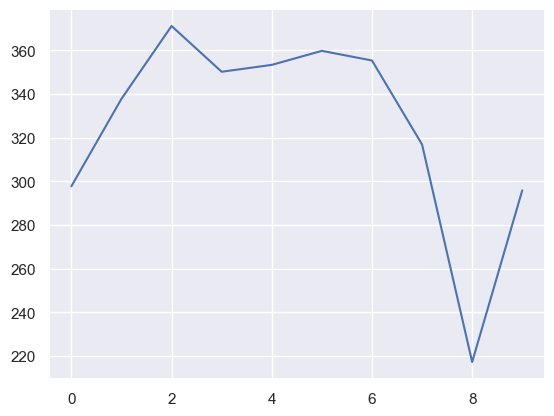

In [732]:
def getGJacobian(j, g):

    numerator1 = numpy.cross(numpy.cross(g[0], j[0]), g[0])
    denominator1 = numpy.linalg.norm(numpy.cross(g[0], j[0]), axis=1)
    grad1 = numpy.divide(numerator1.T, denominator1)
    numerator2 = numpy.cross(numpy.cross(g[1], j[1]), g[1])
    denominator2 = numpy.linalg.norm(numpy.cross(g[1], j[1]), axis=1)
    grad2 = numpy.divide(numerator2.T, denominator2)
    return(numpy.array([grad1.T, grad2.T]))

def getGErrorVector(j, g):
    left = numpy.linalg.norm(numpy.cross(j[0], g[0]), axis=1)
    right = numpy.linalg.norm(numpy.cross(j[1], g[1]), axis=1)
    errs = left - right
    return(errs)
    
# Get error vector
jEstimates = []
squares = []
for j in range(1):
    for i in range(10):
        gErrors = getGErrorVector(jEst, gData)
        sumS = numpy.sum(gErrors**2)
        # if (sumS < 50) & (i > 10):
        #     print(i)
        #     break
        # print(sumS)
        # Calculate Jacobian
        gJacobian = getGJacobian(jEst, gData)
        errJ = gJacobian[0] - gJacobian[1]
        # Calculate pseudoinverce
        gPseudoinverse = numpy.linalg.pinv(gJacobian)
        a = numpy.dot(gPseudoinverse, gErrors)
        # jEst = jEst - a
        aaVec = aaVec - a
        jEst = getJEst(aaVec)
        squares.append(sumS)
    jEstimates.append(jEst)

jEstimates = numpy.array(jEstimates)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# ax.scatter(jEstimates[:, 0, 0], jEstimates[:, 0, 1], jEstimates[:, 0, 2])
seaborn.lineplot(squares)


<AxesSubplot: >

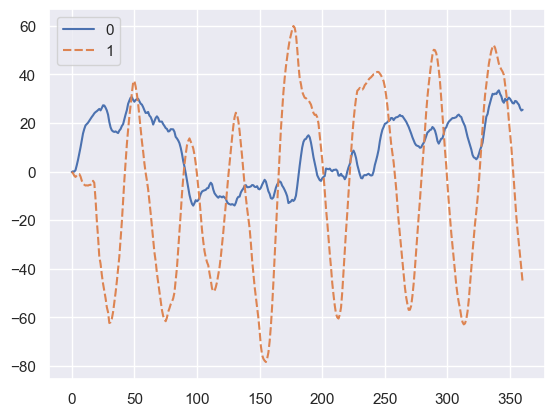

In [733]:

aRates1 = numpy.dot(gData[0], jEst[0])
aRates2 = numpy.dot(gData[1], jEst[1])
aAngles = (aRates1-aRates2) * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])